In [ ]:
#basic model bosphorus

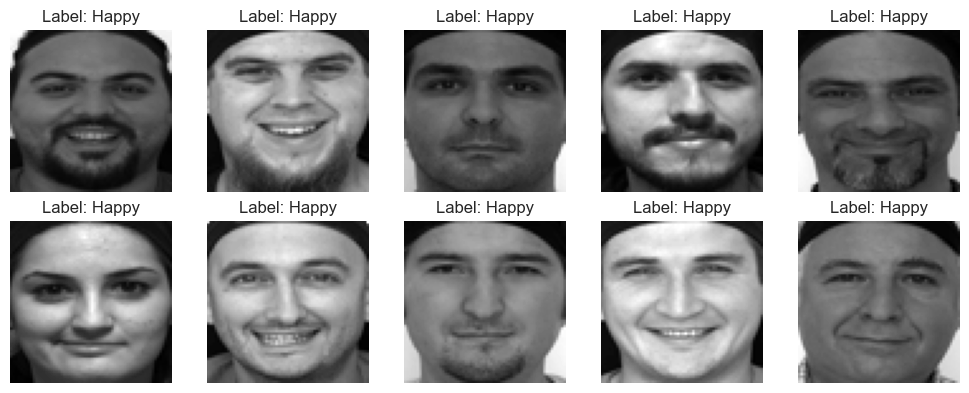

Label distribution:
Happy: 223 images
Sad: 123 images
Fear: 71 images
Surprise: 373 images
Neutral: 143 images
Anger: 347 images
Disgust: 136 images
Running configuration: No Data Augmentation
Test Accuracy: 54.93%
Precision: 0.86
Recall: 0.95
F1 Score: 0.90

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 54.93%
Precision: 0.86
Recall: 0.95
F1 Score: 0.90


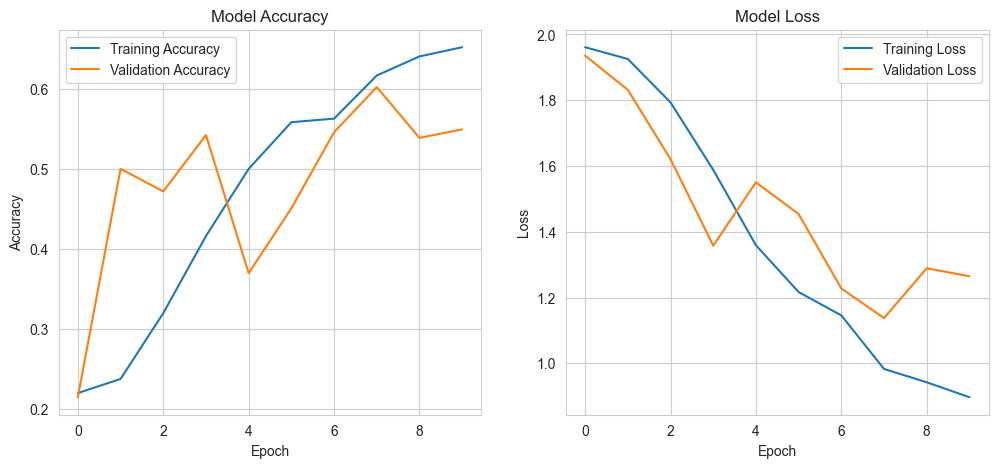

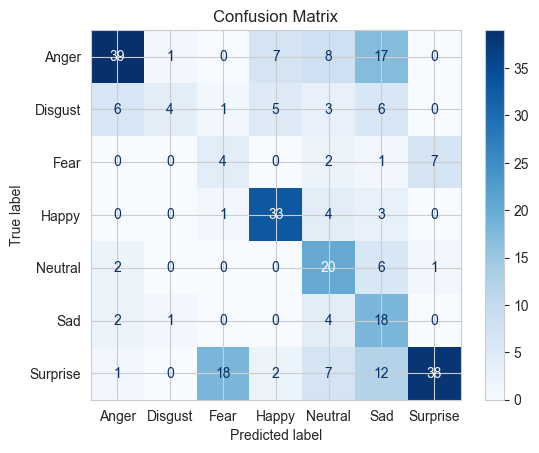

In [10]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Show a few different images with labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i].reshape(64, 64), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


summary of the model architecture and configuration for the Bosphorus dataset, based on the above code:

### **Dataset Preprocessing:**
- **Images**: Loaded from the specified directory, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Reshaping**: Images are reshaped to `(64, 64, 1)` to fit the CNN input requirements.
- **Label Encoding**: Labels (extracted from folder names) are encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: The dataset is split into 80% training and 20% testing.

### **Class Weights:**
- **Handling Imbalance**: Class weights are computed to handle class imbalance during training.

### **CNN Architecture:**
1. **Input Layer**: `(64, 64, 1)` input shape for grayscale images.
    2. **First Conv2D Layer**: 32 filters, `(3x3)` kernel, ReLU activation.
3. **First MaxPooling2D Layer**: Pool size of `(2x2)` to reduce spatial dimensions.
4. **Second Conv2D Layer**: 64 filters, `(3x3)` kernel, ReLU activation.
5. **Second MaxPooling2D Layer**: Pool size of `(2x2)`.
6. **Flatten Layer**: Converts 2D feature maps to 1D vector.
7. **Dense Layer**: 100 neurons, ReLU activation.
8. **Output Layer**: Softmax activation with neurons equal to the number of unique labels (classes).

### **Model Compilation:**
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Data Augmentation:**
- **Configuration**: No data augmentation is applied (all augmentation parameters set to 0 or `False`).

### **Model Training:**
- **Epochs**: 10.
- **Batch Size**: 32.
- **Class Weights**: Applied to account for class imbalance.

### **Evaluation Metrics:**
- **Test Accuracy**: Evaluated on the test set.
- **Precision, Recall, F1 Score**: Calculated to assess the model's performance, especially in terms of handling imbalanced classes.
- **Confusion Matrix**: Generated to visualize the classification performance.

### **Visualization:**
- **Plots**: Accuracy and loss over epochs are plotted for both training and validation sets.
- **Confusion Matrix**: Displayed using a heatmap to show true vs. predicted labels.

This setup is designed for training and evaluating a CNN on the Bosphorus dataset with minimal data augmentation. The results are analyzed through standard classification metrics and visualizations.

In [ ]:
#data aug bosphorus

Label distribution:
Happy: 223 images
Sad: 123 images
Fear: 71 images
Surprise: 373 images
Neutral: 143 images
Anger: 347 images
Disgust: 136 images
Running configuration: No Data Augmentation
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1775 - loss: 1.9766 - val_accuracy: 0.2465 - val_loss: 1.9384
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2275 - loss: 2.0144 - val_accuracy: 0.4225 - val_loss: 1.8660
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3445 - loss: 1.8779 - val_accuracy: 0.4085 - val_loss: 1.7391
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3665 - loss: 1.7997 - val_accuracy: 0.4683 - val_loss: 1.4603
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4712 - loss: 1.4570 - val_accuracy: 0.2711 - val_loss: 1.6815
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5090 - loss: 1.3556 - val_accuracy: 0.4507 - val_loss: 1.4435
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms

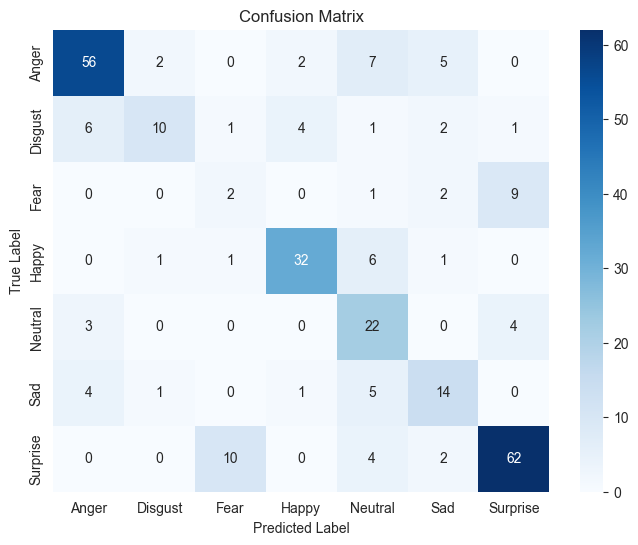

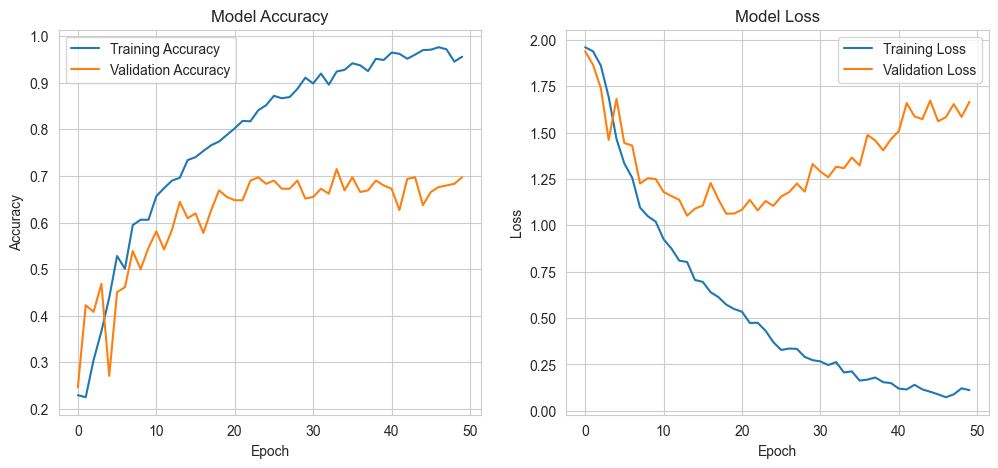

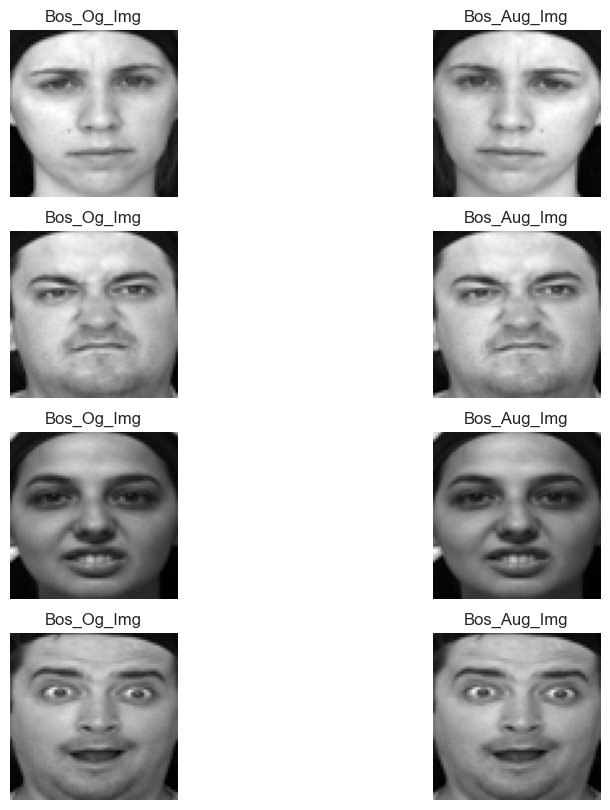

In [1]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": True
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=50,
    class_weight=class_weights_dict,
    verbose=1  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Show original and augmented images side by side

# Select a few random images from the training set
num_images = 4  # Number of images to display
random_indices = np.random.choice(len(X_train), num_images, replace=False)
random_images = X_train[random_indices].reshape(num_images, 64, 64, 1)

# Plot the original and augmented images side by side
plt.figure(figsize=(10, 10))

for i in range(num_images):
    # Generate augmented image
    aug_iter = datagen.flow(random_images[i].reshape(1, 64, 64, 1), batch_size=1)
    augmented_image = next(aug_iter)[0].reshape(64, 64)

    # Plot original image
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(random_images[i].reshape(64, 64), cmap='gray')
    plt.title("Bos_Og_Img")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(augmented_image, cmap='gray')
    plt.title('Bos_Aug_Img')
    plt.axis('off')

plt.show()


code implementing data augmentation for the Bosphorus dataset:

### **Dataset Preprocessing:**
- **Images**: Loaded from the specified directory, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Reshaping**: Images are reshaped to `(64, 64, 1)` to fit the CNN input requirements.
- **Label Encoding**: Labels (extracted from folder names) are encoded using `LabelEncoder` and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: The dataset is split into 80% training and 20% testing.

### **Class Weights:**
- **Handling Imbalance**: Class weights are computed to manage class imbalance during training.

### **CNN Architecture:**
1. **Input Layer**: `(64, 64, 1)` input shape for grayscale images.
    2. **First Conv2D Layer**: 32 filters, `(3x3)` kernel, ReLU activation.
3. **First MaxPooling2D Layer**: Pool size of `(2x2)` to reduce spatial dimensions.
4. **Second Conv2D Layer**: 64 filters, `(3x3)` kernel, ReLU activation.
5. **Second MaxPooling2D Layer**: Pool size of `(2x2)`.
6. **Flatten Layer**: Converts 2D feature maps to a 1D vector.
7. **Dense Layer**: 100 neurons, ReLU activation.
8. **Output Layer**: Softmax activation with neurons equal to the number of unique labels (classes).

### **Model Compilation:**
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Data Augmentation:**
- **Configuration**: Enabled horizontal flipping (`horizontal_flip=True`), no other augmentation applied.

### **Model Training:**
- **Epochs**: 50.
- **Batch Size**: 32.
- **Class Weights**: Applied to account for class imbalance.

### **Evaluation Metrics:**
- **Test Accuracy**: Evaluated on the test set.
- **Precision, Recall, F1 Score**: Calculated to assess the model's performance, especially in terms of handling imbalanced classes.
- **Confusion Matrix**: Generated to visualize the classification performance.

### **Visualization:**
- **Accuracy and Loss Plots**: Training and validation accuracy/loss plotted over epochs.
- **Confusion Matrix**: Displayed using a heatmap to show true vs. predicted labels.
- **Augmented Image Comparison**: Displays original and augmented images side by side to visualize the effect of data augmentation.

This code setup introduces data augmentation, specifically horizontal flipping, to the CNN model for the Bosphorus dataset. The augmentation aims to improve the model's generalization ability by creating slightly varied versions of the original training images. The results are analyzed through standard classification metrics and visualizations.

In [ ]:
# cnn optimization bosphorus

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.1712 - loss: 1.9565 - val_accuracy: 0.1444 - val_loss: 1.9459
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.1545 - loss: 1.9856 - val_accuracy: 0.0915 - val_loss: 1.9362
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1902 - loss: 1.9880 - val_accuracy: 0.2535 - val_loss: 1.8863
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.2403 - loss: 1.8475 - val_accuracy: 0.2148 - val_loss: 1.7851
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3222 - loss: 1.7415 - val_accuracy: 0.3486 - val_loss: 1.6077
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3762 - loss: 1.6153 - val_accuracy: 0.4366 - val_loss: 1.5071
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4395 - loss: 1.5736 - val_accuracy: 0.3239 - val_loss: 1.4690
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4251 - loss: 1.4561 - val_accuracy: 0.4437 - v

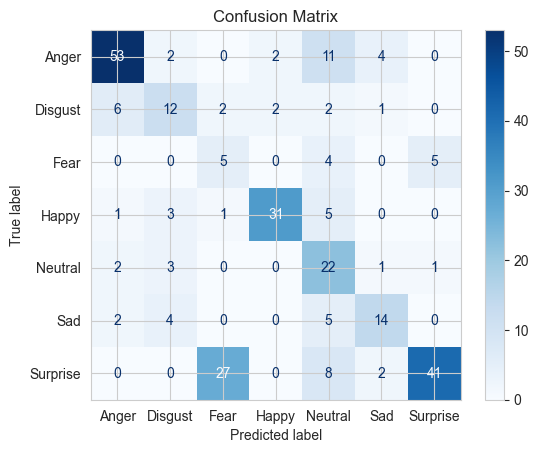

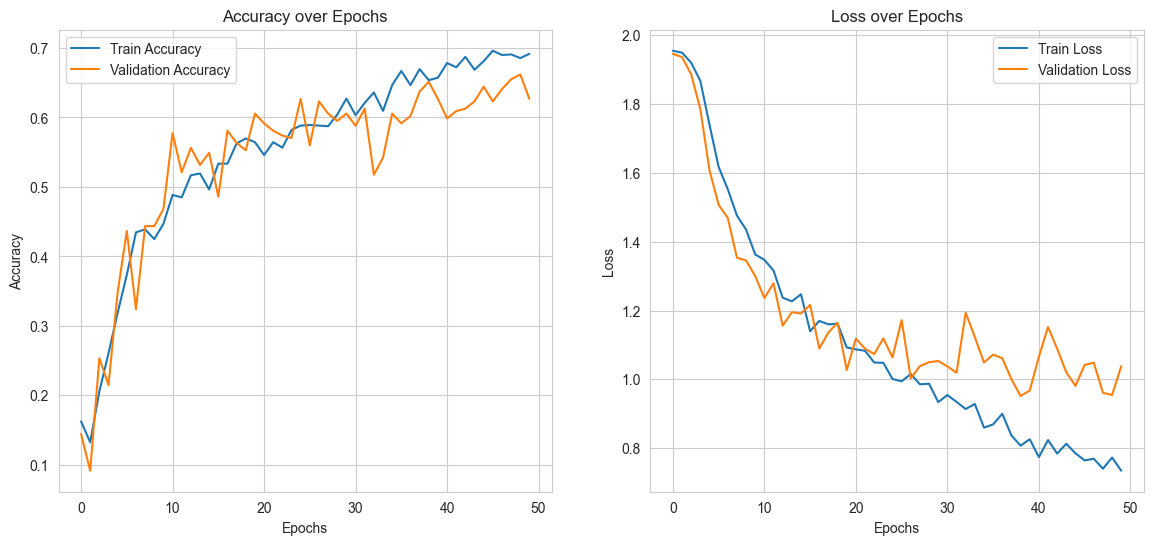

In [18]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
try:
    images, labels = load_images_and_labels(dataset_folder)
    images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input
except Exception as e:
    print(f"Error loading images: {e}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation generator
data_gen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
)

# Specific configuration details
config = {
    'conv_layers': 2,
    'filters': 64,
    'dense_layers': 1,
    'dense_units': 64,
    'dropout': 0.4,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'activation': 'relu',
    'optimizer': 'adam'
}

# Build the model
model = Sequential()
model.add(InputLayer(input_shape=(64, 64, 1)))
for _ in range(config['conv_layers']):
    model.add(Conv2D(config['filters'], kernel_size=(3, 3), activation=config['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
for _ in range(config['dense_layers']):
    model.add(Dense(config['dense_units'], activation=config['activation']))
    model.add(Dropout(config['dropout']))
model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

optimizer_instance = Adam(learning_rate=config['learning_rate'])
model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Train with data augmentation
train_gen = data_gen.flow(X_train, y_train, batch_size=config['batch_size'])
history = model.fit(train_gen, epochs=config['epochs'], validation_data=(X_test, y_test), class_weight=class_weights_dict, verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Precision, Recall, and F1 Score
precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Print the results
print(f"Configuration: {config}")
print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision.result().numpy():.4f}, Recall: {recall.result().numpy():.4f}, F1 Score: {f1_score:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


summary of the model setup and evaluation process based on the above code:

### **Dataset Preprocessing:**
- **Images**: Loaded from a specified folder, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Reshaping**: Images reshaped to `(64, 64, 1)` for CNN input.
- **Label Encoding**: Labels extracted from folder names, encoded using `LabelEncoder`, and converted to one-hot encoding.

### **Data Splitting:**
- **Train/Test Split**: The dataset is split into 80% training and 20% testing.

### **Class Weights:**
- **Handling Imbalance**: Class weights computed to handle class imbalance during training.

### **Data Augmentation:**
- **Configuration**: Horizontal flipping enabled to augment the training data (`horizontal_flip=True`).

### **Model Configuration:**
- **Convolutional Layers**: 2 layers, each with 64 filters, `(3x3)` kernel size, and ReLU activation.
- **Pooling Layers**: MaxPooling with `(2x2)` pool size after each convolutional layer.
- **Dense Layers**: 1 layer with 64 units and ReLU activation.
- **Dropout**: Applied with a rate of 0.4 to reduce overfitting.
- **Output Layer**: Softmax activation with neurons equal to the number of classes.
- **Optimizer**: Adam with a learning rate of 0.001.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.

### **Model Training:**
- **Epochs**: 50.
- **Batch Size**: 32.
- **Training**: Model trained using the data augmentation generator (`ImageDataGenerator`) and class weights.

### **Evaluation Metrics:**
- **Test Accuracy**: Evaluated on the test set.
- **Precision, Recall, F1 Score**: Calculated for a detailed performance analysis.
- **Confusion Matrix**: Generated and displayed to visualize classification performance.

### **Visualization:**
- **Confusion Matrix**: Displayed using a heatmap.
- **Accuracy and Loss Plots**: Plots showing accuracy and loss over epochs for both training and validation sets.

### **Results:**
- **Test Accuracy**: Reflects the overall correctness of predictions.
- **Precision, Recall, F1 Score**: These metrics provide a deeper understanding of how well the model handles class predictions, especially for imbalanced classes.
- **Confusion Matrix**: Provides insight into the true vs. predicted classifications across different classes.

This setup leverages data augmentation, specifically horizontal flipping, to enhance the model's generalization. The results are analyzed through multiple evaluation metrics and visualizations.